# Ground-truth performance and gradient norms

This notebook inspects the initialization schemes for LQGs and time-varying linear policies described in section 5.1 of the [paper](https://www.overleaf.com/read/cmbgmxxpxqzr).

### Checklist

- [x] Fix `n_state`, `n_ctrl`, `horizon`
- [x] Sample random LQGs
- [x] Sample random policies
- [x] Evaluate the expected return
- [x] Evaluate the value gradient norm
- [x] Search numpy, scipy for methods for visualizing the distributions

---
## Linear Quadratic Gaussian (LQG) Problems
In what follows we consider MDPs with:
1. continuous state space $\mathbf{s} \in \mathcal{S} = \mathbb{R}^n$
2. continuous action space $\mathbf{a} \in \mathcal{A} = \mathbb{R}^d$
3. finite time horizon $N \in \mathbb{N}$ and timesteps $t \in \mathcal{T} = \{0, \dots, N - 1\}$
4. time-varying linear Gaussian dynamics 
    $$
    \mathbf{s}_{t+1} \sim p(\cdot| \mathbf{s}_t, \mathbf{a}_t) = \mathcal{N}\left( \cdot ~\middle|~ \mathbf{F}_t \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix} + \mathbf{f}_t, \mathbf{\Sigma}_{t} \right)
    $$
5. time-varying quadratic costs 
    $$
    r_{t+1} = R(\mathbf{s}_t, \mathbf{a}_t) = - \tfrac{1}{2} \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix}^\intercal \mathbf{C}_t \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix} - \mathbf{c}_t^\intercal \begin{bmatrix}\mathbf{s}_t \\ \mathbf{a}_t\end{bmatrix}
    $$
6. Gaussian-distributed initial state 
    $$
    \mathbf{s}_0 \sim \rho = \mathcal{N}(\mathbf{\mu}_\rho, \mathbf{\Sigma}_\rho)
    $$

### Imports

In [1]:
%matplotlib inline
from __future__ import annotations

import textwrap
import warnings
from functools import partial
from typing import Callable, Optional

import lqsvg.envs.lqr.utils as utils
import lqsvg.torch.named as nt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from lqsvg.envs import lqr
from lqsvg.envs.lqr.gym import LQGGenerator
from lqsvg.experiment.models import ExpectedValue, PolicyLoss
from lqsvg.experiment.utils import linear_feedback_distance, linear_feedback_norm
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import place_poles
from scipy.stats import ortho_group
from torch import Tensor
from tqdm.notebook import tqdm

sns.set()

---
## Task selection protocol

$$
    \{ \mathbf{F}_t, \mathbf{f}_t, \mathbf{\Sigma}_t, \mathbf{C}_t, \mathbf{c}_t  \}_{t\in\mathcal{T}} \sim \text{LQGDist}(\texttt{n_state, n_ctrl, horizon}) \\
    \mathbf{\mu}_\rho = \mathbf{0}, \quad \mathbf{\Sigma}_{\rho} = \mathbf{I} \\
    \mathcal{M} = \{ \mathbf{F}_t, \mathbf{f}_t, \mathbf{\Sigma}_t, \mathbf{C}_t, \mathbf{c}_t  \}_{t\in\mathcal{T}} \cup \{ \mathbf{\mu}_\rho, \mathbf{\Sigma}_\rho \}
$$

### LQG generation defaults

- stationary ($\mathbf{F}_t, \mathbf{f}_t, \mathbf{\Sigma}_t, \mathbf{C}_t, \mathbf{c}_t = \mathbf{F}, \mathbf{f}, \mathbf{\Sigma}, \mathbf{C}, \mathbf{c}$)
- passive dynamics eigenvalue norm in $\mathcal{U}(0.5, 1.5)$
  - $\mathbf{F_s} = \mathbf{W}\text{diag}(\lambda_1, \dots, \lambda_n)\mathbf{W}^{-1}$
  - $|\lambda_i| \in [0.5, 1.5], \forall i \in \{1, \dots, n\}$
  - i.e., the passive dynamics may be **unstable**
- **controllable**
- no transition bias ($\mathbf{f} = \mathbf{0}$)
- unit transition covariance ($\mathbf{\Sigma} = \mathbf{I}$)
- unit initial state covariance ($\mathbf{\Sigma}_\rho = \mathbf{I}$)
- no linear cost term ($\mathbf{c} = \mathbf{0}$)
- no state-action cross terms ($\mathbf{C_{sa}, C_{as}} = \mathbf{0, 0}$)

In [2]:
generator = LQGGenerator(
    n_state=2,
    n_ctrl=2,
    horizon=20,
    stationary=True,
    passive_eigval_range=(0.5, 1.5),
    controllable=True,
    transition_bias=False,
    rand_trans_cov=False,
    rand_init_cov=False,
    cost_linear=False,
    cost_cross=False,
)


def sample_lqg(
    n_state: int, n_ctrl: int, horizon: int, n_batch: Optional[int] = None
) -> tuple[lqr.LinSDynamics, lqr.QuadCost, lqr.GaussInit]:
    with generator.config(n_state=n_state, n_ctrl=n_ctrl, horizon=horizon):
        return generator(n_batch)

In [3]:
def print_lqg(dynamics, cost, init):
    msg = f"""\
        dynamics:
            F: {dynamics.F.shape}; {dynamics.F.names}; min={dynamics.F.min()}; max={dynamics.F.max()}
            f: {dynamics.f.shape}; {dynamics.f.names}; min={dynamics.f.min()}; max={dynamics.f.max()}
            Sig: {dynamics.W.shape}; {dynamics.W.names}
        cost:
            C: {cost.C.shape}; {cost.C.names}            
            c: {cost.c.shape}; {cost.c.names}
        init:
            mu: {init.mu.shape}; {init.mu.names}            
            sig: {init.sig.shape}; {init.sig.names}\
        """
    print(textwrap.dedent(msg))
    if "B" not in cost.C.names:
        print("C_0:")
        print(textwrap.indent(str(cost.C.select("H", 0).numpy()), " " * 4))


def test_sample_lqg(n_batch=None):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*Named tensors.*", module="torch")
        dynamics, cost, init = sample_lqg(
            n_state=2, n_ctrl=2, horizon=100, n_batch=n_batch
        )
    assert isinstance(dynamics, lqr.LinSDynamics)
    assert isinstance(cost, lqr.QuadCost)
    assert isinstance(init, lqr.GaussInit)
    print_lqg(dynamics, cost, init)


def test_batch_lqgs():
    test_sample_lqg(n_batch=10)

In [4]:
test_sample_lqg()

dynamics:
    F: torch.Size([100, 2, 4]); ('H', 'R', 'C'); min=-0.8641783595085144; max=0.9291134476661682
    f: torch.Size([100, 2]); ('H', 'R'); min=0.0; max=0.0
    Sig: torch.Size([100, 2, 2]); ('H', 'R', 'C')
cost:
    C: torch.Size([100, 4, 4]); ('H', 'R', 'C')            
    c: torch.Size([100, 4]); ('H', 'R')
init:
    mu: torch.Size([2]); ('R',)            
    sig: torch.Size([2, 2]); ('R', 'C')        
C_0:
    [[ 1.7516049  -0.6692226   0.          0.        ]
     [-0.6692226   0.98605365  0.          0.        ]
     [ 0.          0.          0.2138384   0.28948274]
     [ 0.          0.          0.28948274  2.2663229 ]]


In [5]:
test_batch_lqgs()

dynamics:
    F: torch.Size([100, 10, 2, 4]); ('H', 'B', 'R', 'C'); min=-1.329407811164856; max=1.4356907606124878
    f: torch.Size([100, 10, 2]); ('H', 'B', 'R'); min=0.0; max=0.0
    Sig: torch.Size([100, 10, 2, 2]); ('H', 'B', 'R', 'C')
cost:
    C: torch.Size([100, 10, 4, 4]); ('H', 'B', 'R', 'C')            
    c: torch.Size([100, 10, 4]); ('H', 'B', 'R')
init:
    mu: torch.Size([10, 2]); ('B', 'R')            
    sig: torch.Size([10, 2, 2]); ('B', 'R', 'C')        


---
## Policy selection protocol

In the following we define how to construct time-varying linear deterministic policies.
$$
    \mu_\theta(\mathbf{s}) = \mathbf{a} \\
    \theta = \{ \mathbf{K}_t, \mathbf{k}_t \}_{t\in\mathcal{T}}
$$

### Optimal policies

The following code computes the optimal policy parameters $\{\mathbf{K}_t^\star, \mathbf{k}_t^\star\}_{t\in\mathcal{T}}$ for a given LQG.

In [6]:
def solution(
    dynamics: lqr.LinSDynamics, cost: lqr.QuadCost
) -> tuple[lqr.Linear, lqr.Quadratic, lqr.Quadratic]:
    n_state, n_ctrl, horizon = lqr.dims_from_dynamics(dynamics)
    solver = lqr.NamedLQGControl(n_state, n_ctrl, horizon)
    pistar, qstar, vstar = solver(dynamics, cost)
    return pistar, qstar, vstar


def optimal_policy(dynamics: lqr.LinSDynamics, cost: lqr.QuadCost) -> lqr.Linear:
    pistar, _, _ = solution(dynamics, cost)
    K, k = pistar
    pistar = (K.refine_names(*dynamics.F.names), k.refine_names(*dynamics.f.names))
    return pistar

In [7]:
def print_policy(policy: lqr.Linear):
    K, k = policy
    print(
        f"""
        K: {K.shape}; {K.names}
        k: {k.shape}; {k.names}
    """
    )


def test_optimal_policy():
    dynamics, cost, _ = sample_lqg(n_state=2, n_ctrl=2, horizon=100, n_batch=10)
    print_policy(optimal_policy(dynamics, cost))

In [8]:
test_optimal_policy()


        K: torch.Size([100, 10, 2, 2]); ('H', 'B', 'R', 'C')
        k: torch.Size([100, 10, 2]); ('H', 'B', 'R')
    


### Policies that stabilize systems

The following code tests computing a gain matrix $\mathbf{K}$ such that the closed loop system
$$
    \mathbf{s}' = \left(\mathbf{F_s - F_aK} \right)\mathbf{s}
$$
has eigenvalues $\lambda_i$ such that $|\lambda_i| < 1$, i.e., $\mathbf{K}$ _stabilizes_ the system.

In [9]:
def stabilize_dynamics_poles(A: np.ndarray, B: np.ndarray):
    rng = generator._rng
    #     poles = rng.uniform(low=-1.0, high=1.0, size=A.shape[-1])
    poles = utils.sample_eigvals(A.shape[-1], 0.0, 0.5, size=(), rng=rng)

    return place_poles(A, B, poles, maxiter=100)

In [10]:
def test_pole_placement(print_closed_loop_poles: bool = False):
    with generator.config(
        n_state=3, n_ctrl=2, passive_eigval_range=(0.5, 1.5), controllable=True
    ):
        dynamics = generator.make_dynamics()
        A, B = utils.stationary_dynamics_factors(dynamics)
        A, B = A.numpy(), B.numpy()
        passive_poles, _ = np.linalg.eig(A)

        res = stabilize_dynamics_poles(A, B)

    print("Passive poles:")
    print(passive_poles)
    print("K:")
    print(res.gain_matrix)
    print("Computed poles:")
    print(res.computed_poles)
    print("Requested poles:")
    print(res.requested_poles)
    #     print("X:")
    #     print(res.X)
    print("rtol:")
    print(res.rtol)
    print("nb iter:")
    print(res.nb_iter)

    if print_closed_loop_poles:
        print(np.linalg.eig(A - B @ res.gain_matrix)[0])

In [11]:
test_pole_placement()

Passive poles:
[ 1.3091909 -1.3891109 -1.2812188]
K:
[[-0.58379636 -0.05384924  1.72274929]
 [-0.89651369 -1.06007986  1.07329602]]
Computed poles:
[-0.28671316 -0.24475524  0.10988995]
Requested poles:
[-0.28671329 -0.24475524  0.10989011]
rtol:
0.00029500451129964485
nb iter:
2


### Random policies

The following code defines how to generate _random_ policies that _stabilize_ a given LQG.
$$
    \mathcal{M} \sim \text{LQGDist}(\texttt{n_state, n_ctrl, horizon}) \\
    \{\mathbf{K}_t, \mathbf{k}_t\} \sim \text{PiDist}(\mathcal{M}) \\
    \text{s.t. } \mathbf{K}_t \text{ stabilizes the LQG } \mathcal{M}
$$

In [12]:
def stabilizing_gain(dynamics: lqr.LinSDynamics) -> Tensor:
    F_s, F_a = utils.stationary_dynamics_factors(dynamics)
    A, B = F_s.numpy(), F_a.numpy()
    result = stabilize_dynamics_poles(A, B)
    minus_K = result.gain_matrix
    K = torch.as_tensor(-minus_K).to(F_a).refine_names(*F_a.names)
    return K


def split_dynamics_along_batch(dynamics: lqr.LinSDynamics) -> list[lqr.LinSDynamics]:
    Fs, fs, Ws = map(lambda x: nt.split(x, 1, dim="B"), dynamics)
    return [lqr.LinSDynamics(F=F, f=f, W=W) for F, f, W in zip(Fs, fs, Ws)]


def squeeze_dynamics_batch(dynamics: lqr.LinSDynamics) -> lqr.LinSDynamics:
    F, f, W = (x.squeeze("B") for x in dynamics)
    return lqr.LinSDynamics(F=F, f=f, W=W)


@torch.no_grad()
def sample_policy(dynamics: lqr.LinSDynamics, cost: lqr.QuadCost) -> lqr.Linear:
    assert utils.isstationary(dynamics)
    del cost

    if "B" in dynamics.F.names:
        K = torch.cat(
            [
                stabilizing_gain(squeeze_dynamics_batch(d)).align_to("B", ...)
                for d in split_dynamics_along_batch(dynamics)
            ],
            dim="B",
        )
    else:
        K = stabilizing_gain(dynamics)

    _, F_a = utils.dynamics_factors(dynamics)
    K = K.expand_as(nt.transpose(F_a)).refine_names(*F_a.names)
    # k must be the size of control vectors, which are multiplied by
    # the rows of B (F_a)
    k = torch.zeros_like(F_a.select("R", 0)).rename(C="R")

    random = (K, k)
    return random

In [13]:
def test_sample_policy():
    dynamics, cost, _ = sample_lqg(n_state=3, n_ctrl=2, horizon=100, n_batch=10)
    print_policy(sample_policy(dynamics, cost))

In [14]:
test_sample_policy()


        K: torch.Size([100, 10, 2, 3]); ('H', 'B', 'R', 'C')
        k: torch.Size([100, 10, 2]); ('H', 'B', 'R')
    


We check the distance (L2 norm of the difference) between the random stabilizing parameters and the optimal policy parameters.

In [15]:
def policy_distance(policy_a: lqr.Linear, policy_b: lqr.Linear) -> Tensor:
    return linear_feedback_distance(policy_a, policy_b)

In [16]:
def test_policy_distance():
    dynamics, cost, _ = sample_lqg(n_state=10, n_ctrl=10, horizon=100, n_batch=10)
    optimal = optimal_policy(dynamics, cost)
    random = sample_policy(dynamics, cost)
    distance = policy_distance(optimal, random)
    print(
        f"""\
    Policy distances: 
        {distance}, 
        {distance.shape}\
    """
    )

In [17]:
test_policy_distance()

    Policy distances: 
        tensor([ 462.1163,  625.9892,  118.6681,   70.2696,  134.9255, 3668.0686,
         152.9021,  111.9628,  110.9723,  585.9480]), 
        torch.Size([10])    


We see that stabilizing the system is not sufficient, as the distance to the optimal policy is quite large.

---
## Ground-truth policy performance

<center><b>Sampling</b></center>
$$
    \mathcal{M} \sim \text{LQGDist}(\texttt{n_state, n_ctrl, horizon}) \\
    \theta = \{ \mathbf{K}_t, \mathbf{k}_t \}_{t\in\mathcal{T}} \sim \text{PiDist}(\mathcal{M})
$$
<br>

<center><b>Prediction</b></center>
<!-- LQG prediction can be seen as a function mapping policy parameters (with the dynamics kept constant) to value function coefficients: -->
$$
\left( \mathbf{Q}, \mathbf{q}, q, \mathbf{V}, \mathbf{v}, v \right) = \text{LQGPrediction}(\theta) \\
V^\mu(\mathbf{s}, t) = -\tfrac12 \mathbf{s}^\intercal \mathbf{V}_t(\theta) \mathbf{s} - \mathbf{v}_t(\theta)^\intercal \mathbf{s} - v_t(\theta)
$$
<br>

<center><b>Performance</b></center>
<!-- We can then express policy performance as a direct function of policy parameters: -->
$$
\begin{align}
J(\theta) 
    &= -\mathbb{E}_{\mathbf{s}\sim\rho} \left[ \tfrac12 \mathbf{s}^\intercal \mathbf{V}_0(\theta) \mathbf{s} + \mathbf{v}_0(\theta)^\intercal \mathbf{s} + v_0(\theta) \right] \\
    &= -\text{Tr}(\mathbf{V}_0(\theta)\mathbf{\Sigma}_0) - \mathbf{\mu}_0^\intercal \mathbf{V}_0(\theta) \mathbf{\mu}_0 - \mathbf{v}_0(\theta)^\intercal \mathbf{\mu}_0 - v_0(\theta)
\end{align}
$$

In [18]:
def policy_loss(
    policy: lqr.Linear,
    dynamics: lqr.LinSDynamics,
    cost: lqr.QuadCost,
    init: lqr.GaussInit,
) -> Tensor:
    n_state, n_ctrl, horizon = lqr.dims_from_dynamics(dynamics)
    loss_fn = PolicyLoss(n_state, n_ctrl, horizon)
    loss = loss_fn(policy, dynamics, cost, init)
    return loss


def policy_performance(
    policy: lqr.Linear,
    dynamics: lqr.LinSDynamics,
    cost: lqr.QuadCost,
    init: lqr.GaussInit,
) -> Tensor:
    return -policy_loss(policy, dynamics, cost, init)

In [19]:
def test_policy_loss():
    dynamics, cost, init = sample_lqg(n_state=2, n_ctrl=2, horizon=20, n_batch=10)
    policy = sample_policy(dynamics, cost)
    loss = policy_loss(policy, dynamics, cost, init)
    print(
        f"""\
    Loss: 
        {loss}, 
        ({loss.dtype}), 
        ({loss.shape}); 
    ExpectedReturn: 
        {-loss}, 
        ({(-loss).dtype}), 
        ({loss.shape})\
    """
    )

In [20]:
test_policy_loss()

    Loss: 
        tensor([ 2079.2273,    51.5065,  4511.1499,    75.3262,   142.3242,    62.3319,
        14160.1797,    76.8006,    59.3679,    83.5478], names=('B',)), 
        (torch.float32), 
        (torch.Size([10])); 
    ExpectedReturn: 
        tensor([ -2079.2273,    -51.5065,  -4511.1499,    -75.3262,   -142.3242,
           -62.3319, -14160.1797,    -76.8006,    -59.3679,    -83.5478],
       names=('B',)), 
        (torch.float32), 
        (torch.Size([10]))    


---
## Ground-truth value gradient norm

1. **Sampling**$\rightarrow \mathcal{M}, \theta$; 
2. **Prediction**$\rightarrow \left( \mathbf{Q}, \mathbf{q}, q, \mathbf{V}, \mathbf{v}, v \right)$; 
3. **Performance**$\rightarrow J(\theta)$;
4. **SVG norm**$\rightarrow \| \nabla J(\theta) \|$.

In [21]:
def compute_batched_svg_norm(exp_ret: Tensor, policy: lqr.Linear) -> Tensor:
    for x in policy:
        x.grad = None
    exp_ret.sum().backward()

    K_grad, k_grad = (x.grad.detach() for x in policy)
    return linear_feedback_norm((K_grad, k_grad))


def policy_svg_norm(
    policy: lqr.Linear,
    dynamics: lqr.LinSDynamics,
    cost: lqr.QuadCost,
    init: lqr.GaussInit,
) -> tuple[Tensor, Tensor]:
    eret = policy_performance(policy, dynamics, cost, init)
    svg_norm = compute_batched_svg_norm(eret, policy)
    return eret, svg_norm

In [22]:
def test_random_policy_svg():
    dynamics, cost, init = sample_lqg(n_state=2, n_ctrl=2, horizon=20, n_batch=10)
    policy = tuple(x.requires_grad_(True) for x in sample_policy(dynamics, cost))
    eret, svg_norm = policy_svg_norm(policy, dynamics, cost, init)
    print(
        f"""\
    Expected return: 
        {eret},
        ({eret.dtype},
        {eret.shape})"""
    )
    print(
        f"""\
    SVG norm: 
        {svg_norm},
        ({svg_norm.dtype},
        {svg_norm.shape})"""
    )

In [23]:
test_random_policy_svg()

    Expected return: 
        tensor([ -75.2311,  -60.6328, -368.0799, -123.0209,  -66.2087, -173.2084,
         -91.7721,  -49.2531, -103.2863,  -87.7233], grad_fn=<NegBackward>,
       names=('B',)),
        (torch.float32,
        torch.Size([10]))
    SVG norm: 
        tensor([  7.5506,   6.7075, 101.0554,  14.4051,   7.9690,  73.2749,  18.4405,
          4.4453,  37.1914,   8.9339]),
        (torch.float32,
        torch.Size([10]))


In [24]:
def test_optimal_policy_svg():
    dynamics, cost, init = sample_lqg(n_state=2, n_ctrl=2, horizon=100, n_batch=10)
    pistar, _, vstar = solution(dynamics, cost)
    loss_fn = ExpectedValue()
    eret = -loss_fn(init, tuple(x.select("H", 0) for x in vstar))
    print(
        f"""\
    Optimal expected return: 
        {eret},
        ({eret.dtype})"""
    )

    policy = tuple(x.requires_grad_(True) for x in pistar)
    eret = -policy_loss(policy, dynamics, cost, init)
    print(
        f"""\
    Expected return from Prediction algorithm:
        {eret},
        ({eret.dtype})"""
    )
    svg_norm = compute_batched_svg_norm(eret, policy)
    print(
        f"""\
    Optimal policy SVG norm: 
        {svg_norm},
        ({svg_norm.dtype},
        {svg_norm.shape})"""
    )

In [25]:
test_optimal_policy_svg()

    Optimal expected return: 
        tensor([-108.6797, -609.6851, -160.6953, -364.9062, -610.3920, -331.9527,
        -517.3728, -326.9691, -340.2109, -133.0201], names=('B',)),
        (torch.float32)
    Expected return from Prediction algorithm:
        tensor([-108.6797, -609.6851, -160.6953, -364.9062, -610.3920, -331.9527,
        -517.3728, -326.9691, -340.2109, -133.0201], grad_fn=<NegBackward>,
       names=('B',)),
        (torch.float32)
    Optimal policy SVG norm: 
        tensor([2.1766e-06, 1.0882e-05, 2.1591e-06, 7.1303e-06, 5.8136e-06, 6.7866e-06,
        3.1571e-06, 5.1763e-06, 7.6784e-05, 5.8458e-06]),
        (torch.float32,
        torch.Size([10]))


---
## Beyond averages

Next, we evaluate the distribution of optimal/random policy performances for different LQG problem sizes

### Calculating the expected return (performance) & SVG norm for a batch of LQGs

In [26]:
def expected_return(init: lqr.GaussInit, vval: lqr.Quadratic) -> Tensor:
    expected_value = ExpectedValue()
    expected_cost = expected_value(init, tuple(x.select("H", 0) for x in vval))
    return -expected_cost


def optimal_performance(
    dynamics: lqr.LinSDynamics, cost: lqr.QuadCost, init: lqr.GaussInit
) -> Tensor:
    pistar, qstar, vstar = solution(dynamics, cost)
    return expected_return(init, vstar)


def random_performance(
    dynamics: lqr.LinSDynamics, cost: lqr.QuadCost, init: lqr.GaussInit
) -> Tensor:
    return policy_performance(sample_policy(dynamics, cost), dynamics, cost, init)

In [27]:
@torch.no_grad()
def performance_samples(
    dims: tuple[int, int, int],
    optimal: bool = False,
    samples: int = 100,
    clip_ctrl_dim: bool = False,
) -> np.ndarray:
    n_state, n_ctrl, horizon = dims
    if clip_ctrl_dim and n_ctrl < n_state:
        return np.full((samples,), fill_value=np.nan)

    dynamics, cost, init = sample_lqg(n_state, n_ctrl, horizon, n_batch=samples)

    eret = (optimal_performance if optimal else random_performance)(
        dynamics, cost, init
    )
    return eret.numpy()

### Plotting the optimal cost distribution of controllable/uncontrollable systems

In [28]:
def title_from_dims(dims: tuple[int, int, int]) -> str:
    return "|S|={}, |A|={}, H={}".format(*dims)

In [29]:
def plot_optimal_costs_by_controllability(
    dims: tuple[int, int, int], samples: int = 1000, **kwargs
):
    x = "Cost"
    hue = "Controllable"

    with generator.config(controllable=True, **kwargs):
        controllable = pd.DataFrame(
            {x: -performance_samples(dims, optimal=True, samples=samples)}
        )
        controllable[hue] = True
    with generator.config(controllable=False, **kwargs):
        uncontrollable = pd.DataFrame(
            {x: -performance_samples(dims, optimal=True, samples=samples)}
        )
        uncontrollable[hue] = False

    data = pd.concat([controllable, uncontrollable])

    sns.histplot(
        data=data,
        x=x,
        hue=hue,
        hue_order=[True, False],
        stat="density",
        log_scale=True,
        #         bins=samples // 10
    )
    plt.title(title_from_dims(dims))
    plt.show()

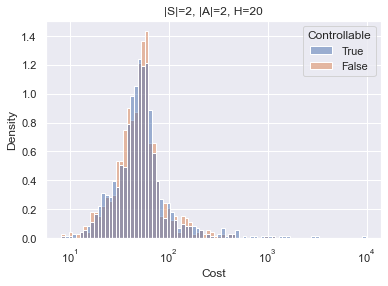

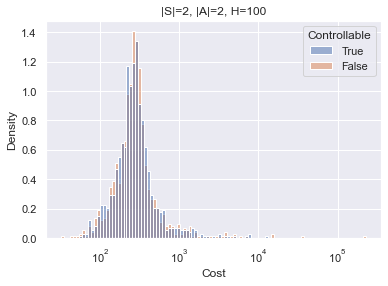

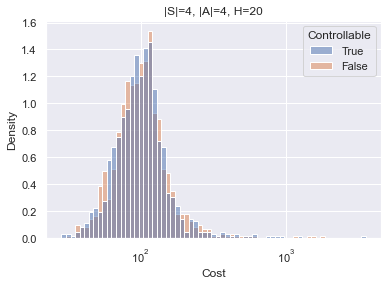

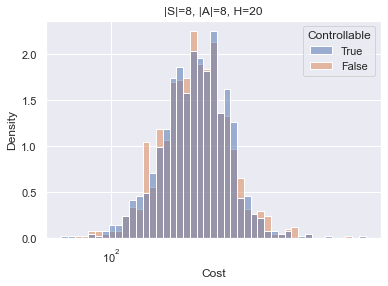

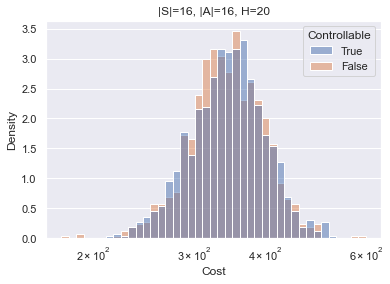

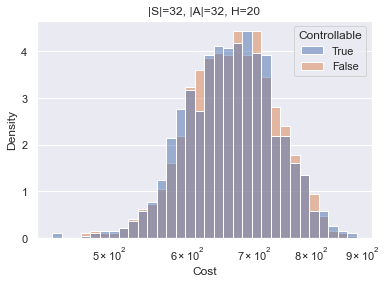

In [30]:
plot_optimal_costs_by_controllability((2, 2, 20))

plot_optimal_costs_by_controllability((2, 2, 100))

plot_optimal_costs_by_controllability((4, 4, 20))

plot_optimal_costs_by_controllability((8, 8, 20))

plot_optimal_costs_by_controllability((16, 16, 20))

plot_optimal_costs_by_controllability((32, 32, 20))

### Plotting the performance distribution of optimal/random policies

In [31]:
def plot_optimal_vs_random_costs_hist(dims: tuple[int, int, int], samples: int = 1000):
    x = "Cost"
    hue = "Optimal"

    optimal = pd.DataFrame(
        {x: -performance_samples(dims, optimal=True, samples=samples)}
    )
    random = pd.DataFrame(
        {x: -performance_samples(dims, optimal=False, samples=samples)}
    )

    optimal[hue] = True
    random[hue] = False
    data = pd.concat([optimal, random])

    sns.histplot(
        data=data,
        x=x,
        hue=hue,
        hue_order=[True, False],
        stat="density",
        log_scale=True,
        bins=samples // 10,
    )
    plt.title(title_from_dims(dims))
    plt.show()

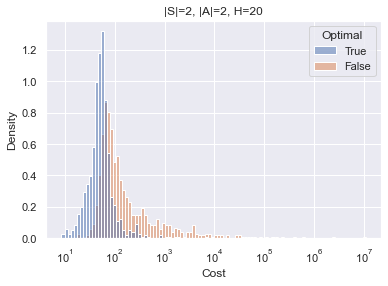

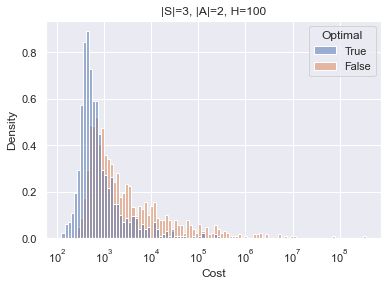

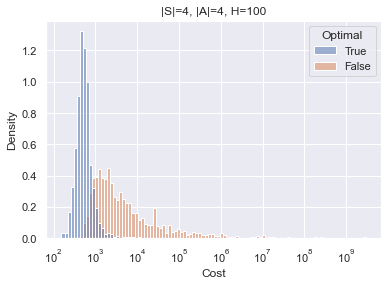

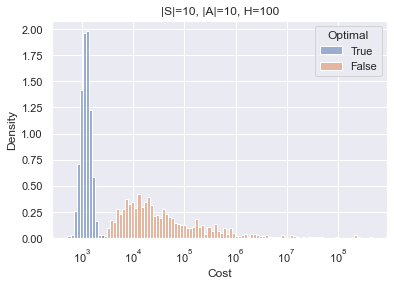

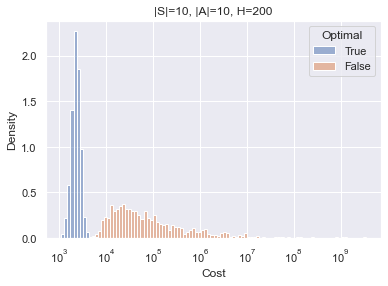

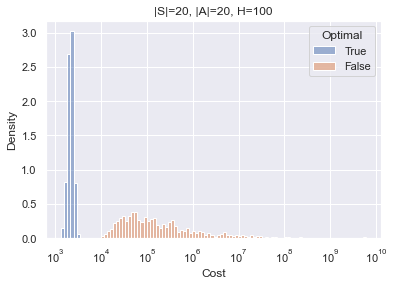

In [32]:
plot_optimal_vs_random_costs_hist((2, 2, 20))

plot_optimal_vs_random_costs_hist((3, 2, 100))

plot_optimal_vs_random_costs_hist((4, 4, 100))

plot_optimal_vs_random_costs_hist((10, 10, 100))

plot_optimal_vs_random_costs_hist((10, 10, 200))

plot_optimal_vs_random_costs_hist((20, 20, 100))

### Plotting the performance distribution of random policies vs. distance to optimal policy

In [33]:
@torch.no_grad()
def performance_and_dist_samples(
    dims: tuple[int, int, int], samples: int = 100
) -> tuple[np.ndarray, np.ndarray]:
    n_state, n_ctrl, horizon = dims
    dynamics, cost, init = sample_lqg(n_state, n_ctrl, horizon, n_batch=samples)

    optimal, _, _ = solution(dynamics, cost)
    random = sample_policy(dynamics, cost)
    performance = policy_performance(random, dynamics, cost, init).numpy()
    distance = policy_distance(random, optimal).numpy()
    return performance, distance

In [34]:
def plot_random_costs_vs_policy_dist(dims: tuple[int, int, int], samples: int = 1000):
    x = "Cost"
    y = "Distance"

    performance, distance = performance_and_dist_samples(dims, samples=samples)
    data = pd.DataFrame({x: -performance, y: distance})

    sns.histplot(
        data=data,
        x=x,
        y=y,
        stat="density",
        log_scale=(True, True),
    )
    plt.title(title_from_dims(dims))
    plt.show()

/Users/angelolovatto/Library/Caches/pypoetry/virtualenvs/lqsvg-kEsPsxvA-py3.8/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


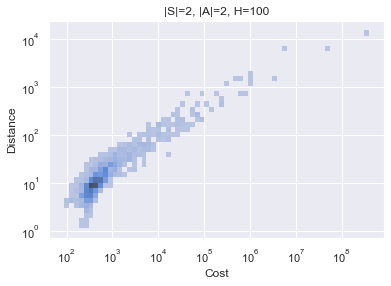

In [35]:
plot_random_costs_vs_policy_dist((2, 2, 100))

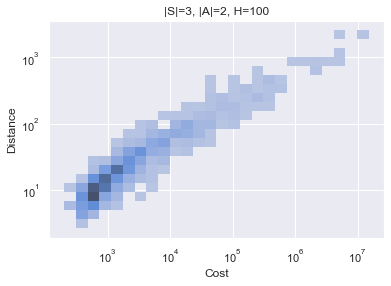

In [36]:
plot_random_costs_vs_policy_dist((3, 2, 100))

### Plotting the SVG norm distribution

In [37]:
def random_svg_norm(
    dynamics: lqr.LinSDynamics, cost: lqr.QuadCost, init: lqr.GaussInit
) -> Tensor:
    policy = tuple(g.requires_grad_(True) for g in sample_policy(dynamics, cost))
    _, svg_norm = policy_svg_norm(policy, dynamics, cost, init)
    return svg_norm


def svg_norm_samples(
    dims: tuple[int, int, int], samples: int = 100, clip_ctrl_dim: bool = False
) -> np.ndarray:
    n_state, n_ctrl, horizon = dims

    if clip_ctrl_dim and n_ctrl < n_state:
        return np.full((samples,), fill_value=np.nan)

    dynamics, cost, init = sample_lqg(n_state, n_ctrl, horizon, n_batch=samples)
    return random_svg_norm(dynamics, cost, init).numpy()

In [38]:
def plot_svg_norm_hist(dims: tuple[int, int, int], samples: int = 1000):
    x = "SVG norm"
    data = pd.DataFrame({x: svg_norm_samples(dims, samples=samples)})
    sns.histplot(data=data, x=x, stat="density", log_scale=True)
    plt.title(title_from_dims(dims))
    plt.show()

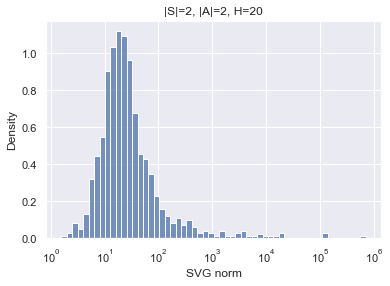

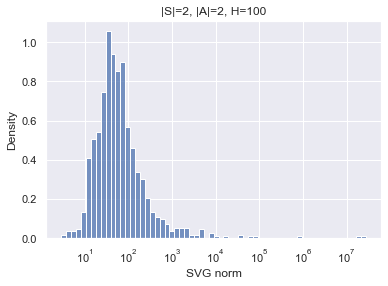

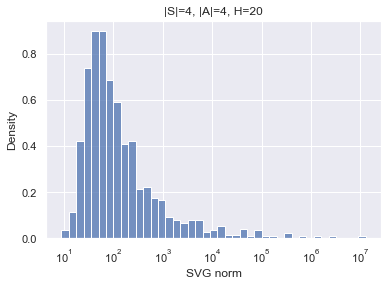

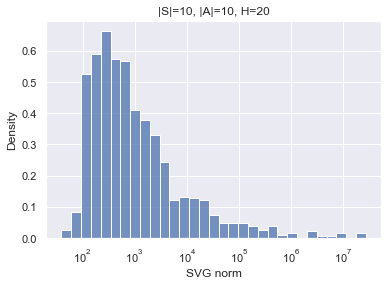

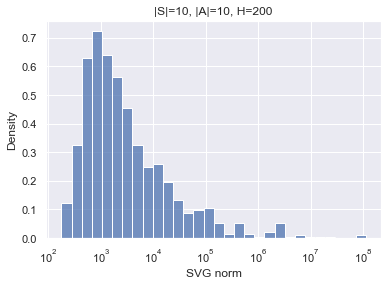

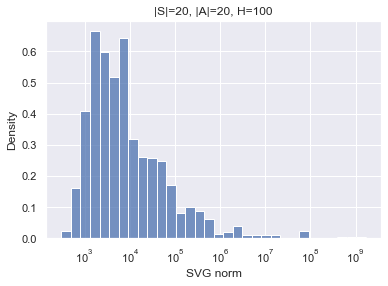

In [39]:
plot_svg_norm_hist((2, 2, 20))

plot_svg_norm_hist((2, 2, 100))

plot_svg_norm_hist((4, 4, 20))

plot_svg_norm_hist((10, 10, 20))

plot_svg_norm_hist((10, 10, 200))

plot_svg_norm_hist((20, 20, 100))

---
## Evaluate cost scaling against each variable

### Checklist
- [x] Stack several LQGs including init dists
- [x] Define range of `n_state`s, `n_ctrl`s, and `horizon`s
- [x] Fix initial values of `n_state=2`, `n_ctrl=2`, `horizon=100`
- [x] Iterate over one of the ranges, e.g., `horizon`s:
  - [x] Generate several LQGs with the current `n_state`, `n_ctrl`, `horizon` and stack them
  - [x] Find the optimal solutions (policies) and evaluate the optimal expected returns
  - [x] Average the results accross the LQGs generated
  - [x] Plot the average against the current `n_state`, `n_ctrl`, `horizon`

In [40]:
def performance_matrix(
    state_dim_arr: np.ndarray,
    ctrl_dim_arr: np.ndarray,
    horizon_arr: np.ndarray,
    perf_sampling_fn: Callable[[int, int, int], np.ndarray],
) -> np.ndarray:
    pbar = tqdm(
        zip(state_dim_arr, ctrl_dim_arr, horizon_arr),
        total=len(ctrl_dim_arr),
        desc="Computing performance by LQG dims",
    )

    exp_ret_arrs = [
        perf_sampling_fn(n_state, n_ctrl, horizon) for n_state, n_ctrl, horizon in pbar
    ]

    exp_ret_mat = np.vstack(exp_ret_arrs)
    return exp_ret_mat

In [41]:
def average_performance_lineplot(
    state_dim: np.ndarray,
    ctrl_dim: np.ndarray,
    horizon: np.ndarray,
    x_axis: tuple[str, np.ndarray],
):
    x, x_arr = x_axis
    y = "average performance"
    hue = "optimal"
    n_samples = 200

    def sampler(s, c, h, *, optimal: bool):
        return performance_samples((s, c, h), samples=n_samples, optimal=optimal)

    optimal = {
        x: x_arr,
        y: performance_matrix(
            state_dim, ctrl_dim, horizon, partial(sampler, optimal=True)
        ).mean(-1),
        hue: np.ones_like(x_arr, dtype=bool),
    }
    random = {
        x: x_arr,
        y: performance_matrix(
            state_dim, ctrl_dim, horizon, partial(sampler, optimal=False)
        ).mean(-1),
        hue: np.zeros_like(x_arr, dtype=bool),
    }

    data = pd.concat(list(map(pd.DataFrame, (optimal, random))))
    ax = sns.lineplot(x=x, y=y, data=data, hue=hue)
    plt.show()

#### Performance vs. state dimension

In [ ]:
x_axis = np.arange(2, 12)
average_performance_lineplot(
    state_dim=x_axis,
    ctrl_dim=np.full(10, 2, dtype=int),
    horizon=np.full(10, 100, dtype=int),
    x_axis=("state dim", x_axis),
)

#### Performance vs. control dimension

In [ ]:
state_dims = np.full(10, 2, dtype=int)
ctrl_dims = np.arange(2, 12)
horizons = np.full(10, 100, dtype=int)
average_performance_lineplot(
    state_dim=state_dims,
    ctrl_dim=ctrl_dims,
    horizon=horizons,
    x_axis=("ctrl dim", ctrl_dims),
)

#### Performance vs. horizon length

In [ ]:
state_dims = np.full(10, 2, dtype=int)
ctrl_dims = np.full(10, 2, dtype=int)
horizons = 100 * np.arange(1, 11)
average_performance_lineplot(state_dims, ctrl_dims, horizons, ("horizon", horizons))

#### Performance vs. state & control dimension

In [ ]:
state_dims = ctrl_dims = np.arange(1, 21) + 1
horizons = np.full(20, 100, dtype=int)
average_performance_lineplot(
    state_dims, ctrl_dims, horizons, ("state & ctrl dim", state_dims)
)

---
## Multivariate analysis of cost scaling

### Checklist
- [x] Plot the average expected return against two variables, e.g., `n_state` and `n_ctrl`, as a 3D surface plot
- [ ] ~Use the insights gained from observing the cost scaling to propose a _downscaling_ parameter for random QuadCosts~
- [x] Use the analysis above to also derive a scale parameter for the random Gaussian noise for policy generation

In [ ]:
def large_fig(*args, scale: float = 2.0, **kwargs):
    return plt.figure(*args, figsize=[scale * 6.4, scale * 4.8], **kwargs)

In [ ]:
def plot_3d_from_2d_function(
    ax,
    xrange: np.ndarray,
    yrange: np.ndarray,
    function: callable[[np.ndarray, np.ndarray], np.ndarray],
):
    length = len(xrange)
    xbatch, ybatch = np.meshgrid(xrange, yrange)
    assert xbatch.shape == ybatch.shape == (length, length)

    x_arr, y_arr = map(lambda x: x.reshape((-1,)), (xbatch, ybatch))
    assert (
        x_arr.shape == y_arr.shape == (length ** 2,)
    ), f"expected: {(length ** 2,)}; x_arr: {x_arr.shape}; y_arr {y_arr.shape}"

    z_arr = function(x_arr, y_arr)
    assert z_arr.shape == x_arr.shape, f"{z_arr.shape} != {x_arr.shape}"

    zbatch = z_arr.reshape(xbatch.shape)
    ax.plot_surface(xbatch, ybatch, zbatch, cmap=cm.coolwarm)

### State vs. control dimension with fixed horizon

In what follows we set the horizon length to 100 steps.

#### Best expected return

In [ ]:
def performances_by_state_ctrl_dim(
    state_dim_arr: np.ndarray, ctrl_dim_arr: np.ndarray, horizon: int, optimal: bool
) -> np.ndarray:
    horizon_arr = np.full_like(state_dim_arr, fill_value=horizon)
    exp_opt_ret_mat = performance_matrix(
        state_dim_arr,
        ctrl_dim_arr,
        horizon_arr,
        lambda s, c, h: performance_samples(
            (s, c, h), optimal=optimal, samples=100, clip_ctrl_dim=False
        ),
    )
    return exp_opt_ret_mat

In [ ]:
def average_performance_by_state_ctrl_dim(
    state_dim_arr: np.ndarray, ctrl_dim_arr: np.ndarray, optimal: bool
) -> np.ndarray:
    z_arr = performances_by_state_ctrl_dim(
        state_dim_arr, ctrl_dim_arr, horizon=100, optimal=optimal
    ).mean(axis=-1)
    # Filtering NaNs
    z_arr = np.nan_to_num(z_arr, nan=np.nanmin(z_arr))
    return z_arr

In [ ]:
fig = large_fig()
ax = fig.add_subplot(projection="3d")
plot_3d_from_2d_function(
    ax,
    xrange=np.arange(1, 21) + 1,
    yrange=np.arange(1, 21) + 1,
    function=lambda x, y: average_performance_by_state_ctrl_dim(x, y, optimal=True),
)
ax.set_xlabel("state dim")
ax.set_ylabel("ctrl dim")
ax.set_title("average best performance")
plt.show()

#### Expected return from random policy

In [ ]:
fig = large_fig()
ax = fig.add_subplot(projection="3d")
plot_3d_from_2d_function(
    ax,
    xrange=np.arange(1, 21) + 1,
    yrange=np.arange(1, 21) + 1,
    function=lambda x, y: average_performance_by_state_ctrl_dim(x, y, optimal=False),
)
ax.set_xlabel("state dim")
ax.set_ylabel("ctrl dim")
ax.set_title("average random performance")
plt.show()

### State & control dimension vs. horizon length

#### Best expected return

In [ ]:
def performances_by_horizon(
    state_ctrl_dim: np.ndarray, horizon_arr: np.ndarray, optimal: bool
) -> np.ndarray:
    state_dim_arr = ctrl_dim_arr = state_ctrl_dim
    opt_perf_mat = performance_matrix(
        state_dim_arr,
        ctrl_dim_arr,
        horizon_arr,
        lambda s, c, h: performance_samples((s, c, h), optimal=optimal, samples=100),
    )
    return opt_perf_mat

In [ ]:
def average_performance_by_horizon(
    state_ctrl_dim: np.ndarray, horizon_arr: np.ndarray, optimal: bool
) -> np.ndarray:
    z_arr = performances_by_horizon(state_ctrl_dim, horizon_arr, optimal=optimal).mean(
        axis=-1
    )
    # Filtering NaNs
    z_arr = np.nan_to_num(z_arr, nan=np.nanmin(z_arr))
    return z_arr

In [ ]:
fig = large_fig()
ax = fig.add_subplot(projection="3d")
plot_3d_from_2d_function(
    ax,
    xrange=np.arange(1, 21) + 1,
    yrange=100 + 10 * np.arange(1, 21),
    function=lambda x, y: average_performance_by_horizon(x, y, optimal=True),
)
ax.set_xlabel("state/ctrl dim")
ax.set_ylabel("horizon")
ax.set_title("average optimal performance")
plt.show()

#### Random expected return

In [ ]:
fig = large_fig()
ax = fig.add_subplot(projection="3d")
plot_3d_from_2d_function(
    ax,
    xrange=np.arange(1, 21) + 1,
    yrange=100 + 10 * np.arange(1, 21),
    function=lambda x, y: average_performance_by_horizon(x, y, optimal=False),
)
ax.set_xlabel("state/ctrl dim")
ax.set_ylabel("horizon")
ax.set_title("average random performance")
plt.show()